# 0. Install Dependencies and Bring in Data

In [1]:
%pip install tensorflow tensorflow-gpu pandas matplotlib sklearn

Defaulting to user installation because normal site-packages is not writeable
  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  Preparing metadata (setup.py) ... done
  Using cached python_version-0.0.2-py2.py3-none-any.whl (3.4 kB)
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [18 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "/private/var/folders/f7/ysfqdk0d1436n973y5_w27b00000gn/T/pip-install-cglkw8rt/tensorflow-gpu_e17eb97b3f0f45ea930cf784da9c05a7/setup.py", line 37, in <module>
          raise Exception(TF_REMOVAL_WARNING)
      Exception:
      
      The "tensorflow-gpu" package has been removed!
      
      Please install "tensorflow" instead.
      
      Other than the name, the two packages have been identical
      since TensorFlow 2.1, or roughly since Sep 2019. F

In [2]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [3]:
df = pd.read_csv('/Users/kevinmathew/Documents/Dissertation/jigsaw-toxic-comment-classification-challenge/train.csv')

In [4]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


# 1. Preprocess

In [5]:
from keras.layers import TextVectorization

In [6]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [7]:
MAX_FEATURES = 200000 # number of words in the vocab

In [8]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



In [9]:
vectorizer.adapt(X.values)

In [10]:
vectorized_text = vectorizer(X.values)

In [11]:
#MCSHBAP - map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps bottlenecks

In [12]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

# 2. Create Sequential Model

In [13]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding
from keras import regularizers

In [14]:
model = Sequential()
# Create the embedding layer 
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer 
model.add(Dense(6, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirection  (None, 64)                16640     
 al)                                                             
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [15]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [16]:
history = model.fit(train, epochs=3, validation_data=val)

Epoch 1/3
6981/6981 [==============================] - 2245s 321ms/step - loss: 0.0632 - val_loss: 0.0475
Epoch 2/3
6981/6981 [==============================] - 2005s 287ms/step - loss: 0.0458 - val_loss: 0.0405
Epoch 3/3
6981/6981 [==============================] - 4820s 691ms/step - loss: 0.0424 - val_loss: 0.0376


In [17]:
from matplotlib import pyplot as plt

<Figure size 800x500 with 0 Axes>

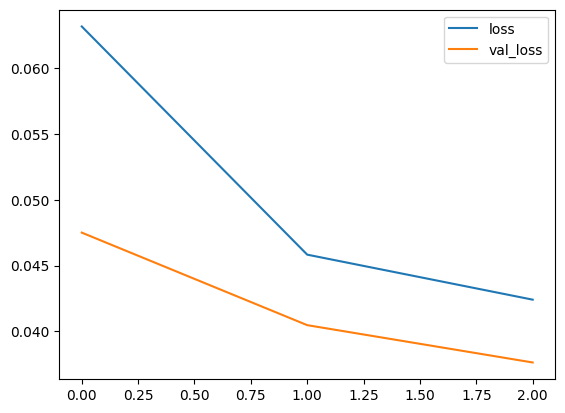

In [18]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

# 3. Make Predictions

In [19]:
batch = test.as_numpy_iterator().next()

In [52]:
input_text = vectorizer('KILLLL YOUUUU BITCH!')

In [53]:
model.predict(np.expand_dims(input_text,0))

1/1 [==============================] - 0s 181ms/step


array([[0.99705565, 0.18706988, 0.96304476, 0.01837447, 0.7797527 ,
        0.09797704]], dtype=float32)

In [22]:
res = model.predict(np.expand_dims(input_text,0))

1/1 [==============================] - 0s 173ms/step


In [23]:
(res > 0.5).astype(int)

array([[1, 0, 1, 0, 1, 0]])

# 4. Evaluate Model

In [24]:
from keras.metrics import Precision, Recall, CategoricalAccuracy

In [25]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [26]:
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

1/1 [==============================] - 0s 88ms/step


In [27]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.853958010673523, Recall:0.7287014126777649, Accuracy:0.9949849843978882


In [49]:
model.save('toxicity.h5')

In [32]:
model = tf.keras.models.load_model('/Users/kevinmathew/Documents/Content-creation-engine/lstm_engine/toxicity.h5')